# Adaptive Scale Selection AMPD (ASS-AMPD)
Here, we look into signals that are quasi-periodic locally, but have variable scale across the timeseries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import sin, pi
from scipy.signal import find_peaks_cwt
from pyampd.ampd import find_peaks, find_peaks_original, find_peaks_adaptive
import matplotlib.pyplot as plt

## Create fake signal

In [3]:
def fake_timeseries(tmax=30, seed=None, dilation=1.):
    """Generate fake data for testing peak detection algorithms"""
    np.random.seed(seed)
    fs, f1, f2, f3 = 20, dilation * 1, dilation * 2, dilation * 0.1
    a, b, c, d = 1, 0.6, 1, 1.
    N = int(tmax*fs)
    t = np.linspace(0, tmax, N)
    x = a*sin(2*pi*f1*t) + b*sin(2*pi*f2*t) + c*sin(2*pi*f3*t) + d*np.random.rand(N)
    return t, x

## Compare peak detect methods

In [4]:
methods = [
    ('ass_ampd_50', lambda x: find_peaks_adaptive(x, window=50)),
    ('ass_ampd_100', lambda x: find_peaks_adaptive(x, window=100)),
    ('ass_ampd_200', lambda x: find_peaks_adaptive(x, window=200)),
    ('ampd', find_peaks)
]
styles = ['rs', 'go', 'bx', 'cs', 'mo']

### Create a signal with distinct regions characterised by different frequency/scale content

In [5]:
t1, x1 = fake_timeseries(tmax=10, seed=0)
t2, x2 = fake_timeseries(tmax=10, seed=1, dilation=3.1)
t = np.hstack([t1, t1[-1]+ t2 + 1/20])
x = np.hstack([x1, x2 - x2[0] + x1[1]])

In [6]:
all_pks = [method(x) for name, method in methods]

/Users/igor/.pyenv/versions/3.6.4/envs/pyampd/lib/python3.6/site-packages/scipy/signal/signaltools.py:2535: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coef, resids, rank, s = linalg.lstsq(A, newdata[sl])


Text(0, 0.5, 'signal')

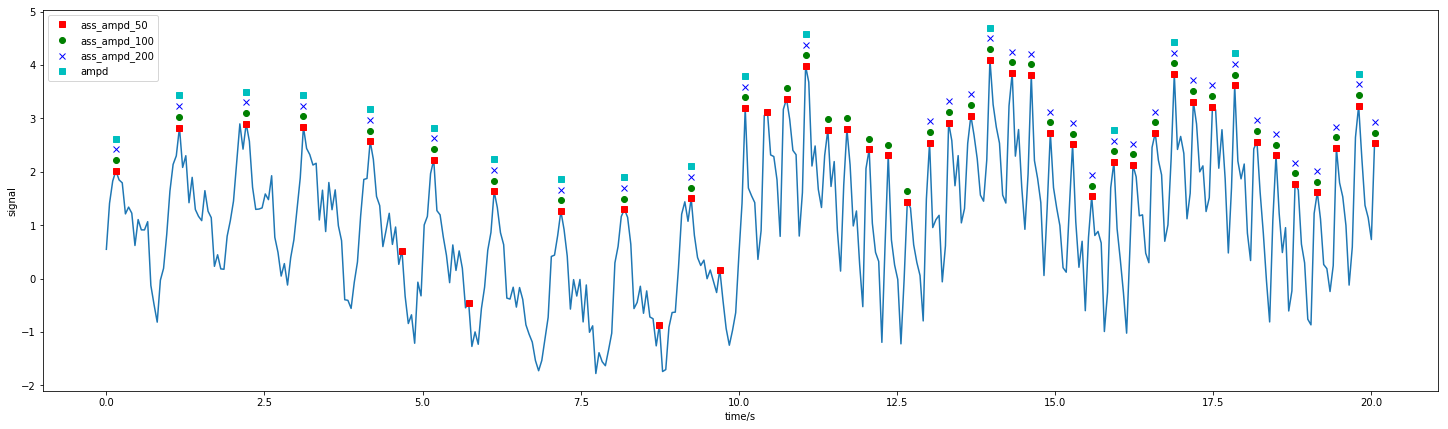

In [7]:
plt.figure(figsize=(25, 7))
plt.plot(t, x, '-')
for idx in range(len(methods)):
    pks = all_pks[idx]
    offset = idx * 0.2
    style = styles[idx]
    name = methods[idx][0]
    plt.plot(t[pks], offset + x[pks], style, label=name)
plt.legend()
plt.xlabel('time/s')
plt.ylabel('signal')

## Compare timing

In [8]:
t, x = fake_timeseries(tmax=1000, seed=0)
print('{} samples over {} s'.format(len(x), t[-1]))

20000 samples over 1000.0 s


In [9]:
methods = [
    ('ass_ampd_200', lambda x: find_peaks_adaptive(x, window=200)),
    ('ass_ampd', lambda x: find_peaks_adaptive(x, window=None)),
    ('ampd', find_peaks),
]
for name, method in methods:
    print('timing "{}":'.format(name.upper()))
    %time pks = method(x)
    print()

timing "ASS_AMPD_200":
CPU times: user 126 ms, sys: 28 ms, total: 154 ms
Wall time: 40 ms

timing "ASS_AMPD":
CPU times: user 5.72 s, sys: 1.92 s, total: 7.64 s
Wall time: 7.31 s

timing "AMPD":
CPU times: user 728 ms, sys: 98.3 ms, total: 826 ms
Wall time: 478 ms



## Adaptive LSM

In [10]:
t1, x1 = fake_timeseries(tmax=15, seed=0)
t2, x2 = fake_timeseries(tmax=15, seed=1, dilation=3.1)
t = np.hstack([t1, t1[-1]+ t2 + 1/20])
x = np.hstack([x1, x2 - x2[0] + x1[1]])

In [11]:
pks, LSM, adaptive_scale = find_peaks_adaptive(x, window=100, debug=True)
L, N = LSM.shape

Text(0, 0.5, 'scale')

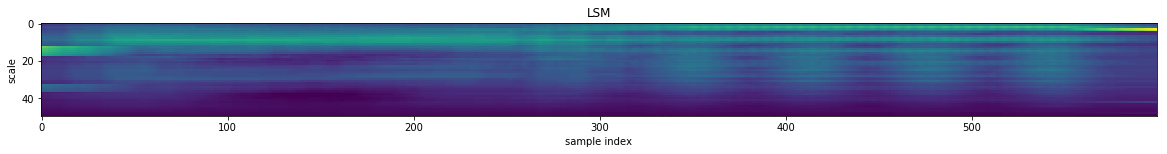

In [12]:
fig, ax0 = plt.subplots(ncols=1, figsize=(20, 7))
ax = ax0
ax.imshow(LSM)
ax.set_title('LSM')
ax.set_xlabel('sample index')
ax.set_ylabel('scale')

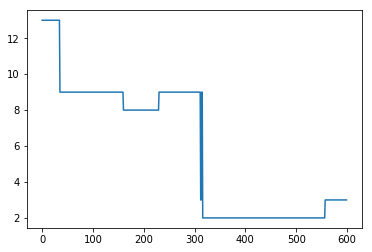

In [13]:
plt.plot(adaptive_scale)

Text(0, 0.5, 'signal')

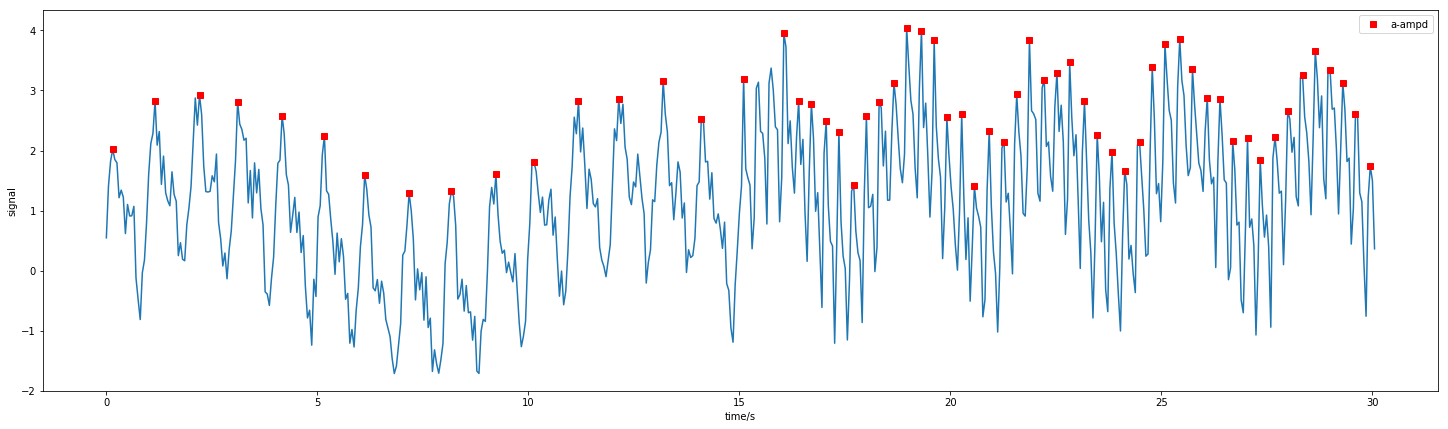

In [14]:
plt.figure(figsize=(25, 7))
plt.plot(t, x, '-')
plt.plot(t[pks], x[pks], 'rs', label='a-ampd')
plt.legend()
plt.xlabel('time/s')
plt.ylabel('signal')